In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! cp "/content/gdrive/My Drive/racedata/graydata/GrayA" /content/
! cp "/content/gdrive/My Drive/racedata/graydata/GrayB" /content/

cp: -r not specified; omitting directory '/content/gdrive/My Drive/racedata/graydata/GrayA'
cp: -r not specified; omitting directory '/content/gdrive/My Drive/racedata/graydata/GrayB'


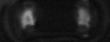

In [2]:
from PIL import Image
img = Image.open('/content/gdrive/MyDrive/racedata/graydata/GrayA/0/20190802023050_8SSB20N60164H1DG97Y02G6_R1248_1_SolderLight.png')
img

In [3]:
# load the Keras libraries.
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [4]:
img_width, img_height = 224, 224
nb_train_samples = 12000
nb_validation_samples = 200
epochs = 100
batch_size = 32
n_classes = 8

In [5]:
train_data_dir = "/content/gdrive/MyDrive/racedata/graydata/GrayA/"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    validation_split= 0.2,
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset= "training"
    )

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset= "validation"
    )

Found 9604 images belonging to 8 classes.
Found 2396 images belonging to 8 classes.


In [6]:
test_data_dir = "/content/gdrive/MyDrive/racedata/graydata/GrayB/"
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1. / 255)
new_test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')


Found 200 images belonging to 8 classes.


In [7]:
def build_model():
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     weights='imagenet', #add
                                     include_top=False,
                                     pooling='avg')
    for layer in base_model.layers:
      layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [8]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

29097984/29084464 [==============================] - 0s 0us/step


In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [10]:
model_history = model.fit_generator(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
301/301 [==============================] - 5034s 17s/step - loss: 36.6990 - acc: 0.8457 - mse: 0.0311 - val_loss: 2.9630 - val_acc: 0.7708 - val_mse: 0.0472
Epoch 2/100
301/301 [==============================] - 249s 827ms/step - loss: 2.3294 - acc: 0.8954 - mse: 0.0183 - val_loss: 2.4978 - val_acc: 0.8229 - val_mse: 0.0306
Epoch 3/100
301/301 [==============================] - 234s 779ms/step - loss: 2.2352 - acc: 0.9101 - mse: 0.0169 - val_loss: 2.8339 - val_acc: 0.8438 - val_mse: 0.0329
Epoch 4/100
301/301 [==============================] - 227s 756ms/step - loss: 2.1629 - acc: 0.9190 - mse: 0.0151 - val_loss: 2.3074 - val_acc: 0.7917 - val_mse: 0.0266
Epoch 5/100
301/301 [==============================] - 222s 736ms/step - loss: 2.1374 - acc: 0.9278 - mse: 0.0142 - val_loss: 2.0772 - val_acc: 0.9219 - val_mse: 0.0124
Epoch 6/100
301/301 [==============================] - 206s 685ms/step - loss: 2.0913 - acc: 0.9390 - mse: 0.0122 - val_loss: 2.3622 - val_acc: 0.8333 - va

In [11]:
#model.save('Densenetmodel.h5')
model.save('/content/gdrive/MyDrive/racedata/GrayDenseNetmodel.h5')

In [12]:
import os
import pandas as pd
dir = "/content/gdrive/MyDrive/racedata/graydata/GrayB/"
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        #print(filename)
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':
                #print(os.path.split(dirname))
                label.append(os.path.split(dirname)[1][0])
                path.append(os.path.join(dirname,filename))
                print(os.path.join(dirname,filename))
df2 = pd.DataFrame(columns = ['path','label'])
df2['path'] = path
df2['label'] = label

/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200222044818_R970_1.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200504150301_8SSB20N60289H1DG04T01MP_R2009_1_view53.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200223150214_R853_1.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20190904063111_R26.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200504230945_8SSB20N60289H1DG04T00S6_R988_1_view51.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20191111193431_8SSB20N60289H1DG9B9086G_R723_1_view12.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200504115757_8SSB20N60289H1DG04T0224_R2238_1_view50.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200504124805_8SSB20N60522H1DG053014W_R861_1_view10.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20190816114533_R936.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/20200504201737_8SSB20N60289H1DG04T012Y_R779_1_view60.png
/content/gdrive/MyDrive/racedata/graydata/GrayB/0/2020042

In [13]:
df2 = df2.sample(frac = 1)
df2 = df2.groupby(['label']).head(1000)
df2['label'] = df2['label'].astype('category')
df2['label'].value_counts()

0    130
7     10
6     10
5     10
4     10
3     10
2     10
1     10
Name: label, dtype: int64

0
1
2
3
4
5
6
7
Accuracy Score: 0.405


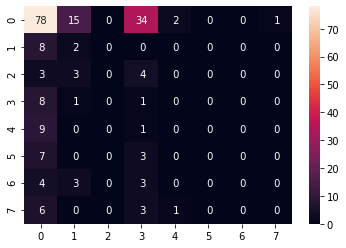

In [14]:
#以A80%訓練20%驗證 再以B測試
import numpy as np
import seaborn as sns
pred = model.predict(new_test_data)
pred=np.argmax(pred,axis=1)
pred_df=df2.copy()
labels={}
for l,v in new_test_data.class_indices.items():
    print(l)
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])
    
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

                                                  path label pred
103  /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
155  /content/gdrive/MyDrive/racedata/graydata/Gray...     3    3
122  /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
88   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
63   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
77   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
123  /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
47   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
85   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0
46   /content/gdrive/MyDrive/racedata/graydata/Gray...     0    0


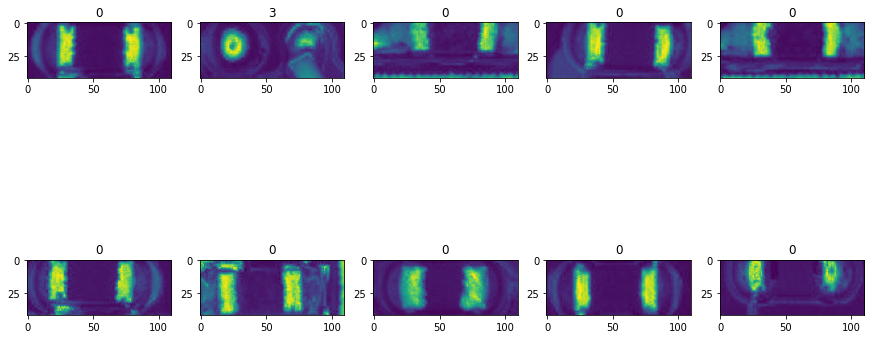

In [22]:
import matplotlib.pyplot as plt
print(pred_df[pred_df['label']==pred_df['pred']].head(10))
fig, ax=plt.subplots(nrows=2, ncols=5, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['label']==pred_df['pred']].head(10).reset_index()
for i in range(0,10):
    ax[i].imshow(plt.imread(imlist['path'][i]))
    ax[i].set_title(imlist['label'][i])